In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
import pickle
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split

from util import CustomLoss, CustomFeaturesDataset

import datetime

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

save_dir = Path("../../features_model/{date:%d-%m_%H-%M}".format(date=datetime.datetime.now()))
save_dir.mkdir(parents=True, exist_ok=True)

In [2]:
#### Load and process dataset ####
with open("../../data/dataset.pkl", "rb") as f:
    data = pickle.load(f)

# Split training and testing dataset
print(data.shape)
(n_samples, sample_dims) = data.shape
batch_size = 50


# Re-normalize (but correctly this time)
xs = 30*data[:,-3]
ys = (24*data[:,-2])-12

print("[", np.min(xs), np.max(xs), "]")
print("[", np.min(ys), np.max(ys), "]")

data[:,-3] = (1/40)*(xs+20)
data[:,-2] = (1/48)*(xs+24)

print("[", np.min(data[:,-2]), np.max(data[:,-2]), "]")
print("[", np.min(data[:,-3]), np.max(data[:,-3]), "]")


(8000, 1445)
[ -18.598706842042162 19.042522297209743 ]
[ -20.419581689645362 22.611010817254197 ]
[ 0.11252694079078829 0.896719214525203 ]
[ 0.035032328948945944 0.9760630574302436 ]


In [3]:
dataset = CustomFeaturesDataset(data, 3)
train, valid, test = random_split(dataset,[3/4, 1/8, 1/8])

# Save datasets
with open(save_dir / "train_dataset.pkl", "wb") as f:
    pickle.dump(train, f)
with open(save_dir / "valid_dataset.pkl", "wb") as f:
    pickle.dump(valid, f)
with open(save_dir / "test_dataset.pkl", "wb") as f:
    pickle.dump(test, f)

# Create dataloaders
trainloader = DataLoader(train, batch_size=batch_size)
validloader = DataLoader(valid, batch_size=batch_size)

In [4]:
#### Defining parameters and model ####
num_epochs = 1000

model = nn.Sequential(
    nn.Linear(721*2, 32),
    nn.ReLU(),
    nn.Linear(32, 3),
    nn.Sigmoid()
)
model.to(device)

loss_function = CustomLoss()
loss_function.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

In [5]:
#### Training ####
train_loss = []
valid_loss = []
valid_loss_lowpass = []
window = 50

for epoch in trange(num_epochs):
    #Train set
    epoch_loss = 0
    for batch_in, batch_feats in trainloader:
        # Forward pass 
        outputs = model(batch_in)
        loss = loss_function(outputs, batch_feats)
        epoch_loss += loss

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss.append(epoch_loss)

    # Validation set
    epoch_loss = 0
    for batch_in, batch_feats in validloader:
        outputs = model(batch_in)
        loss = loss_function(outputs, batch_feats)
        epoch_loss += float(loss)
    valid_loss.append(epoch_loss)
    valid_loss_lowpass.append(np.mean(valid_loss[epoch-window:epoch]))
    
    # If the validation error is going up, save model
    if epoch > window+10 and valid_loss_lowpass[epoch-1]>max(valid_loss_lowpass[epoch-10:epoch-2]):
        torch.save(model, save_dir / f'model_{epoch}.pth')
 


  0%|          | 0/1000 [00:00<?, ?it/s]c:\Users\Louise\Documents\EPFL\UPRAMDYA_intern\Flygym\flyvenv\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Louise\Documents\EPFL\UPRAMDYA_intern\Flygym\flyvenv\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 1000/1000 [11:45<00:00,  1.42it/s]


In [6]:
#### Saving and plotting results ####
torch.save(model, save_dir / f'model_{epoch}.pth')

with open(save_dir / "train_loss.pkl", "wb") as f:
    pickle.dump(train_loss, f)
with open(save_dir / "valid_loss.pkl", "wb") as f:
    pickle.dump(valid_loss, f)


371


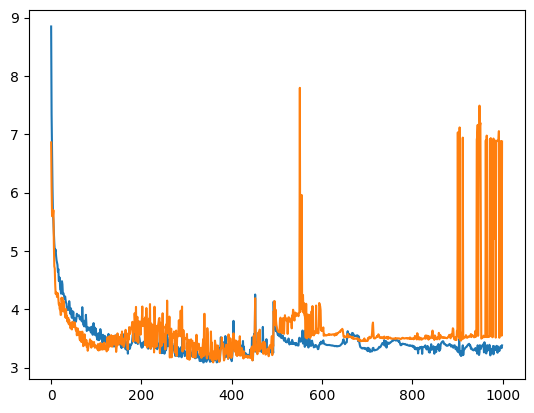

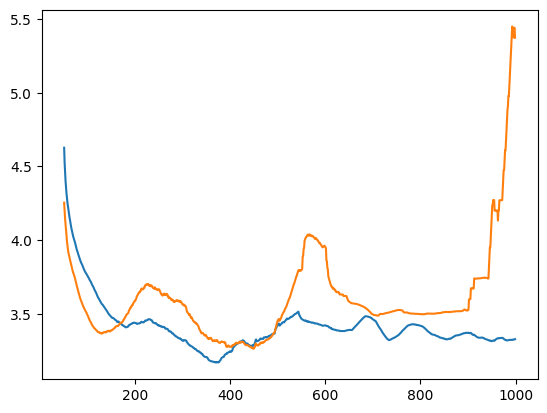

In [10]:
load_dir = save_dir #Path("../../features_model/10-08_12-02")

with open(load_dir / "train_loss.pkl", "rb") as f:
    train_loss = pickle.load(f)
with open(load_dir / "valid_loss.pkl", "rb") as f:
    valid_loss = pickle.load(f)

train_loss = torch.tensor(train_loss).detach().numpy()
valid_loss = torch.tensor(valid_loss).detach().numpy()

window = 50
avg_train = [np.mean(train_loss[i:i+window])/6 for i in range(len(train_loss)-window)]
avg_valid = [np.mean(valid_loss[i:i+window]) for i in range(len(valid_loss)-window)]

print(np.argmin(avg_train)+window)

plt.plot(range(num_epochs), train_loss/6)
plt.plot(range(num_epochs), valid_loss)
plt.show()

plt.plot(range(window, num_epochs), avg_train)
plt.plot(range(window, num_epochs), avg_valid)
plt.show()

In [18]:
test_loss = []
for num in [373,426,453,714,903]:
    with open(f"../../features_model/10-08_15-53/model_{num}.pth","rb") as f:
        model = torch.load(f)
    model.eval()

    tot_loss = 0
    testloader = DataLoader(test, batch_size=1)
    for test_in, test_feats in trainloader:
        outputs = model(test_in)
        loss = loss_function(outputs, test_feats)

    test_feats[:,-3] = 40*test_feats[:,-3]-20
    test_feats[:,-2] = 48*test_feats[:,-2]-24

    outputs[:,-3] = 40*outputs[:,-3]-20
    outputs[:,-2] = 48*outputs[:,-2]-24


    for idx, feat in enumerate(test_feats):
        print("Real features : ", feat)
        print("Predicted features : ", outputs[idx].detach().numpy())

        
        in_coord = outputs[idx,:2]
        in_m = outputs[idx,2]
        targ_coord = feat[:2]
        targ_m = feat[2]

        mloss = float(10*F.mse_loss(torch.mul(targ_m,in_coord.T).T, targ_coord))
        bloss = float(F.binary_cross_entropy(in_m, targ_m))
        print("Loss : ", mloss, bloss, mloss+bloss)
        tot_loss+= mloss+bloss
    test_loss.append(tot_loss)


Real features :  tensor([-0.6223, -0.6223,  1.0000])
Predicted features :  [0.64395773 0.6194511  1.        ]
Loss :  15.727563858032227 0.0 15.727563858032227
Real features :  tensor([-6.3512, -6.3512,  1.0000])
Predicted features :  [0.35700107 0.3842769  1.        ]
Loss :  451.8299865722656 0.0 451.8299865722656
Real features :  tensor([-2.3399, -2.3399,  1.0000])
Predicted features :  [0.45584434 0.46542618 1.        ]
Loss :  78.42769622802734 0.0 78.42769622802734
Real features :  tensor([7.5610, 7.5610, 1.0000])
Predicted features :  [0.61186767 0.5921964  1.        ]
Loss :  484.2703552246094 0.0 484.2703552246094
Real features :  tensor([-3.5462, -3.5462,  1.0000])
Predicted features :  [0.22576667 0.26937234 0.9999908 ]
Loss :  143.92958068847656 9.179157132166438e-06 143.9295898676337
Real features :  tensor([3.6508, 3.6508, 1.0000])
Predicted features :  [0.5288249 0.5256089 1.       ]
Loss :  97.56468200683594 0.0 97.56468200683594
Real features :  tensor([0.3597, 0.3597,

In [17]:
print(test_loss)

[4.2912483707989395, 4.496832380767415, 5.190761773535101, 4.752619490318594, 4.723943486191374]
